# Import Utilities

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir('/content/gdrive/My Drive/DS532')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import numpy as np
import pandas as pd
comments = pd.read_csv("comment_bangkok-hospital.csv")

In [3]:
comments

,comment,score,hospital,en
0,คุณหมอที่แผนกอายุรกรรมเป็นกันเอง วินิจฉัยถูกโร...,4,Bangkok Hospitol,Doctor of Medicine at the front friendly. The ...
1,เคยไปรักษาตัวอยู่ที่แผนกจิตรักษ์ แผนกดูแลเรื่อ...,5,Bangkok Hospitol,Been to maintain the spiritual care department...
2,บริการดีมาก รวดเร็ว พาแขกคนจีนไปก็มีล่ามจีนแปล...,3,Bangkok Hospitol,Very quick service takes guests to the Chinese...
3,มีการบริการดี คุณหมอมีความรู้ความสามารถมาก และ...,4,Bangkok Hospitol,A good service You are very knowledgeable. May...
4,บริการดีมากชัดเจนดีพยาบาลก็พูดดีบุคลากรพูดดีหม...,5,Bangkok Hospitol,"Service very good, clear medical personnel say..."
...,...,...,...,...
236,โรงพยาบาลสะอาด /การดูแลของแพทย์และเอาใจใส่เป็น...,5,Bangkok Hospitol,Hospital cleaning / Physician care and attenti...
237,เกิดที่รพ..นี้ จนตอนนี้ 30 กว่าปีคุณหมอหรือพยา...,5,Bangkok Hospitol,There was a hospital. It is now more than 30 y...
238,สะดวกใส่ใจทุกรายบะเอียดบริการเป็นเลิศ,5,Bangkok Hospitol,Attentive service every minuscule Chiba servic...
239,วันนี้ไปหาหมอที่รพ.นี้ เป็นรพ.ที่ดีมาก เพราะที...,5,Bangkok Hospitol,"Today, a doctor at the hospital now. The hospi..."


In [0]:
from tqdm import tqdm_notebook

# Read data

In [0]:
rama = pd.read_csv("comment_bangkok-hospital.csv")
rama = rama.reset_index()
rama = rama.rename(columns={"index": "cid"})

# Sentence Tokenize

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from nltk import sent_tokenize

sentences = []
cids = []
for cid in rama["cid"]:
    s = sent_tokenize(rama.loc[cid, "en"])
    sentences = sentences + s
    cids = cids + [cid] * len(s)

# Sentence-level sentiment

In [8]:
import nltk
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
!pip install twython

In [0]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [0]:
def predict_sentiment(sentence):
  sa = SentimentIntensityAnalyzer()
  sentiment_distribution = sa.polarity_scores(sentence)
  score = sentiment_distribution.get("compound")
  
  if score >= 0.05:
    return "positive"
  elif score <= -0.05:
    return "negative"
  else:
    return "neutral"

In [12]:
sentiments = []
for sentence in tqdm_notebook(sentences, total=len(sentences)):
    sentiments.append(predict_sentiment(sentence))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


# Parsing

In [13]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
from nltk import word_tokenize, pos_tag, RegexpParser

In [0]:
grammar = """NP: {<NN|NNS>+}
                 {<NN|NNS>+<CC><NN|NNS>+}"""
chunker = RegexpParser(grammar)
parse_trees = []
for sentence in sentences:
    parse_trees.append(chunker.parse(pos_tag(word_tokenize(sentence))))

In [16]:
parse_trees

[Tree('S', [Tree('NP', [('Doctor', 'NN')]), ('of', 'IN'), ('Medicine', 'NNP'), ('at', 'IN'), ('the', 'DT'), Tree('NP', [('front', 'NN')]), ('friendly', 'RB'), ('.', '.')]),
 Tree('S', [('The', 'DT'), Tree('NP', [('disease', 'NN')]), ('is', 'VBZ'), ('diagnosed', 'JJ'), ('quickly', 'RB'), ('Doctor', 'NNP'), ('explains', 'VBZ'), ('fine', 'JJ'), ('Pretty', 'NNP'), ('good', 'JJ'), Tree('NP', [('care', 'NN')]), ('of', 'IN'), Tree('NP', [('employees', 'NNS')]), ('notice', 'VBP'), ('a', 'DT'), ('smaller', 'JJR'), Tree('NP', [('jar', 'NN'), ('queue', 'NN')]), ('as', 'RB'), ('well', 'RB'), ('informed', 'JJ'), Tree('NP', [('patient', 'NN')]), ('always', 'RB'), ('.', '.')]),
 Tree('S', [('Waited', 'VBD'), ('a', 'DT'), ('long', 'JJ'), Tree('NP', [('time', 'NN')]), ('coming', 'VBG'), (',', ','), ('but', 'CC'), ('if', 'IN'), ('the', 'DT'), Tree('NP', [('patient', 'NN')]), ('is', 'VBZ'), ('cold', 'JJ'), (',', ','), ('but', 'CC'), ('I', 'PRP'), ('was', 'VBD'), ('a', 'DT'), ('little', 'JJ'), Tree('NP', 

# Extract Noun Phrase

In [0]:
def extract_np(parsed_tree):
    nps = []
    for subtree in parsed_tree.subtrees():
        if subtree.label() == 'NP':
            t = subtree
            t = " ".join(word for word, tag in t.leaves())
            nps.append(t)
    return nps

In [0]:
nps = []
for parse_tree in parse_trees:
    nps.append(extract_np(parse_tree))

In [19]:
nps

[['Doctor', 'front'],
 ['disease', 'care', 'employees', 'jar queue', 'patient'],
 ['time', 'patient', 'bit'],
 [],
 ['people'],
 ['match', 'results', 'lab'],
 ['care department'],
 ['care', 'patients'],
 ['nurses', 'nature', 'disease', 'disease'],
 ['worsen', 'sets', 'experience', 'model', 'weeks'],
 ['Hospitals', 'symptoms'],
 ['activities'],
 ['yoga classes', 'classes', 'talk', 'psychotherapist'],
 ['concerns'],
 ['psychologist'],
 ['medication', 'check', 'psychiatrist'],
 ['love'],
 ['service', 'guests', 'people', 'interpreters', 'quality'],
 ['service'],
 ['love', 'everyone'],
 ['quality service'],
 ['personnel',
  'time',
  'treatment',
  'everything',
  'ants',
  'treatments',
  'results'],
 [],
 [],
 [],
 ['pregnancy', 'women', 'doctors', 'nurses', 'care'],
 ['child', 'circumcision son'],
 ['cut wounds', 'doctor appointments', 'order', 'lesion'],
 ['milk', 'milk'],
 ['milk ducts massage'],
 [],
 ['time',
  'lives',
  'decisions',
  'doctors',
  'times',
  'hospital',
  'emergenc

# Put information into DataFrame

In [0]:
df = pd.DataFrame({"cids": cids, 
                   "sentences": sentences, 
                   "sentiments": sentiments, 
                   "NP": nps})

In [21]:
df.head(10)

,cids,sentences,sentiments,NP
0,0,Doctor of Medicine at the front friendly.,positive,"[Doctor, front]"
1,0,The disease is diagnosed quickly Doctor explai...,positive,"[disease, care, employees, jar queue, patient]"
2,0,"Waited a long time coming, but if the patient ...",negative,"[time, patient, bit]"
3,0,"Overall, then it's hard.",negative,[]
4,0,Quick and easy good for people who do not want...,positive,[people]
5,0,But if the match has to wait for lab results t...,neutral,"[match, results, lab]"
6,1,Been to maintain the spiritual care department.,positive,[care department]
7,1,Department of care of psychiatric patients.,positive,"[care, patients]"
8,1,All nurses understand the nature of the diseas...,neutral,"[nurses, nature, disease, disease]"
9,1,No worsen All sets come with great experience ...,negative,"[worsen, sets, experience, model, weeks]"


In [0]:
df['sentences'] = df['sentences'].str.replace("[^a-zA-Z#]", " ")

In [0]:
df['sentiments'] = df['sentiments'].str.replace("[^a-zA-Z#]", " ")

# Split dataframe into positive and negative sentiment

In [0]:
pos = df[df["sentiments"] == "positive"].reset_index(drop=True)
pos_words = sum(pos["NP"].tolist(), [])
pos_words = [word.lower() for word in pos_words]
poshist = pd.DataFrame({"words": pos_words})
poshist = poshist.groupby("words").size().reset_index(name="#pos")

In [0]:
neg = df[df["sentiments"] == "negative"].reset_index(drop=True)
neg_words = sum(neg["NP"].tolist(), [])
neg_words = [word.lower() for word in neg_words]
neghist = pd.DataFrame({"words": neg_words})
neghist = neghist.groupby("words").size().reset_index(name="#neg")

# Word Cloud Representation

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [0]:
def vizwordcloud(df):
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

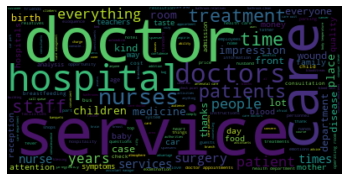

In [28]:
vizwordcloud(poshist)

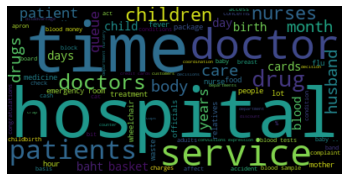

In [29]:
vizwordcloud(neghist)

We saw 2 problems: 1) Singular and plural words were not combined and 2) words that should not be appeared in the wordcloud such as *patients* because of the co-reference resolution problem.  

Let's transfrom selected words to their singular form because at this stage the number of words is not much already then add categories to filter out.

In [0]:
def plural2singular(word):
  if word == "doctors":
    return "doctor"
  elif word == "nurses":
    return "nurse"
  elif word == "clinics":
    return "clinic"
  elif word == "hospitals":
    return "hospital"
  elif word == "services":
    return "service"
  elif word == "staffs":
    return "staff"
  elif word == "treatments":
    return "treatment"
  elif word == "students":
    return "student"
  else:
    return word

In [0]:
pos_words = [plural2singular(word) for word in pos_words]
poshist = pd.DataFrame({"words": pos_words})
poshist = poshist.groupby("words").size().reset_index(name="#pos")

neg_words = [plural2singular(word) for word in neg_words]
neghist = pd.DataFrame({"words": neg_words})
neghist = neghist.groupby("words").size().reset_index(name="#neg")

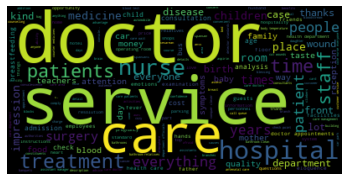

In [32]:
vizwordcloud(poshist)

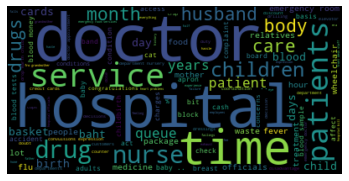

In [33]:
vizwordcloud(neghist)

In [0]:
def groups(word):
    if word in ("doctor", "nurse", "student"):
        return "staff"
    elif word in ("hospital", "clinic", "equipment", "place"):
        return "infrastructure"
    elif word in ("service", "care", "treatment", "surgery", "disease", "medical care"):
        return "service"
    elif word in ("queue", "appointment"):
        return "process"
    elif word in ("price", "claim"):
        return "finance"
    else:
        return "others"

In [0]:
poshist["category"] = poshist["words"].apply(lambda x: groups(x))
poscount = poshist.groupby("category").size().reset_index(name="#")
poscount = poscount[poscount["category"] != "others"].reset_index(drop=True)

In [0]:
neghist["category"] = neghist["words"].apply(lambda x: groups(x))
negcount = neghist.groupby("category").size().reset_index(name="#")
negcount = negcount[negcount["category"] != "others"].reset_index(drop=True)

# Plot Radar Chart

In [37]:
poscount

,category,#
0,finance,1
1,infrastructure,3
2,process,2
3,service,5
4,staff,2


In [38]:
negcount

,category,#
0,finance,1
1,infrastructure,1
2,process,1
3,service,4
4,staff,2


In [0]:
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode,  plot

In [40]:
fig = px.line_polar(poscount, r="#", theta="category", line_close=True)
plot(fig)

'temp-plot.html'

In [41]:
fig_2 = px.line_polar(negcount, r="#", theta="category", line_close=True)
plot(fig_2)

'temp-plot.html'

#Extracting Features from cleaned comments

In [0]:
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(df['sentences'])

df_bow = pd.DataFrame(bow.todense())

df_bow

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
756,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
#Term Frequency-Inverse Document Frequency (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(df['sentences'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

df_tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.369428,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308025,0.000000,0.0,0.0,0.0,0.0,0.393993,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.387738,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.508998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
756,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
757,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#Splitting our dataset into Training and Validation Set

In [45]:
train_bow = bow[:31962]
train_bow.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [46]:
#Using features from TF-IDF for training set
train_tfidf_matrix = tfidf_matrix[:31962]

train_tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [47]:
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder ()
df['sentiments'] = number.fit_transform(df['sentiments'].astype('str'))
df

,cids,sentences,sentiments,NP
0,0,Doctor of Medicine at the front friendly,2,"[Doctor, front]"
1,0,The disease is diagnosed quickly Doctor explai...,2,"[disease, care, employees, jar queue, patient]"
2,0,Waited a long time coming but if the patient ...,0,"[time, patient, bit]"
3,0,Overall then it s hard,0,[]
4,0,Quick and easy good for people who do not want...,2,[people]
...,...,...,...,...
754,240,A good The treatment process is a conventional...,2,"[treatment process, hospital, city, restaurant..."
755,240,went to a few Hospital in Bangkok is another t...,0,"[Hospital, flu]"
756,240,And common diseases that are not very serious,2,[diseases]
757,240,But I do not really know that this is my exper...,1,[expertise]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



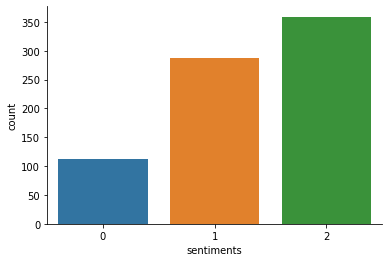

In [48]:
# Neutral label : 0 , Negative label : 1 , Positive  label : 2
import seaborn as sns
sns.countplot(df['sentiments'])
sns.despine()

In [0]:
#Splitting the data into training and validation set
from sklearn.model_selection import train_test_split

In [0]:
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow,df['sentiments'],test_size=0.3,random_state=0)

In [0]:
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,df['sentiments'],test_size=0.3,random_state=0)

In [52]:
x_train_bow.shape

(531, 482)

In [53]:
x_valid_bow.shape

(228, 482)

In [54]:
y_train_bow.shape

(531,)

In [55]:
y_valid_bow.shape

(228,)

#Applying Machine Learning Models

In [0]:
from sklearn.metrics import f1_score

In [0]:
from sklearn.linear_model import LogisticRegression
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs')

In [58]:
Log_Reg.fit(x_train_bow,y_train_bow)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
prediction_bow = Log_Reg.predict_proba(x_valid_bow)

prediction_bow

array([[1.10752602e-01, 7.18264675e-01, 1.70982722e-01],
       [2.22053728e-01, 5.05953153e-01, 2.71993119e-01],
       [2.46492431e-01, 4.49353247e-01, 3.04154322e-01],
       [1.78413397e-01, 5.76249491e-01, 2.45337111e-01],
       [1.32024764e-01, 3.40502910e-01, 5.27472326e-01],
       [4.01255347e-02, 9.10476472e-02, 8.68826818e-01],
       [1.33569779e-01, 5.81323705e-01, 2.85106516e-01],
       [2.18493039e-02, 1.52307963e-01, 8.25842733e-01],
       [1.35987385e-01, 4.49779435e-01, 4.14233180e-01],
       [2.87799367e-01, 1.07126447e-02, 7.01487989e-01],
       [1.17776912e-01, 4.89168570e-01, 3.93054518e-01],
       [1.21030060e-01, 6.49837457e-01, 2.29132483e-01],
       [1.26719148e-01, 4.38822688e-01, 4.34458164e-01],
       [1.98382240e-01, 5.15578823e-01, 2.86038937e-01],
       [1.61967440e-01, 7.26383410e-01, 1.11649150e-01],
       [7.30932628e-02, 7.65203080e-01, 1.61703657e-01],
       [2.31133359e-02, 7.01843632e-02, 9.06702301e-01],
       [1.70599340e-01, 5.85010

In [60]:
#Calculating the F1 score
# if prediction is equal to 2 else 1 where 2 is for positive comments and 1 for negative sentiment comments
prediction_int = prediction_bow[:,1]>=0.3

# converting the results to integer type
prediction_int = prediction_int.astype(np.int)
prediction_int

# calculating f1 score
log_bow = f1_score(y_valid_bow, prediction_int,average='micro')

log_bow

0.4078947368421052

In [61]:
Log_Reg.fit(x_train_tfidf,y_train_tfidf)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [62]:
prediction_tfidf = Log_Reg.predict_proba(x_valid_tfidf)

prediction_tfidf

array([[0.13129866, 0.58743063, 0.28127071],
       [0.19301761, 0.45431381, 0.35266857],
       [0.20639424, 0.41236716, 0.3812386 ],
       [0.16318106, 0.49059469, 0.34622424],
       [0.1321753 , 0.41016594, 0.45765876],
       [0.13435382, 0.3048878 , 0.56075838],
       [0.14554829, 0.48178759, 0.37266412],
       [0.07041519, 0.22526356, 0.70432124],
       [0.13220155, 0.46989617, 0.39790229],
       [0.21073428, 0.22109734, 0.56816839],
       [0.13207897, 0.43692887, 0.43099216],
       [0.14005286, 0.4855055 , 0.37444164],
       [0.13868288, 0.30145881, 0.55985831],
       [0.18558051, 0.37767042, 0.43674907],
       [0.15166962, 0.54913479, 0.29919558],
       [0.13973965, 0.56008773, 0.30017262],
       [0.03800546, 0.0532337 , 0.90876084],
       [0.18180873, 0.45559774, 0.36259353],
       [0.09046959, 0.53438334, 0.37514707],
       [0.1274363 , 0.62131503, 0.25124867],
       [0.08968146, 0.22985269, 0.68046585],
       [0.10577845, 0.47245941, 0.42176213],
       [0.

In [63]:
prediction_int_tfidf = prediction_tfidf[:,1]>=0.3

prediction_int_tfidf = prediction_int.astype(np.int)
prediction_int_tfidf

# calculating f1 score
log_tfidf = f1_score(y_valid_tfidf, prediction_int_tfidf,average='micro')

log_tfidf

0.4078947368421052

In [64]:
#XGBoost
from xgboost import XGBClassifier
model_bow = XGBClassifier(random_state=0,learning_rate=0.9)
model_bow.fit(x_train_bow, y_train_bow)
xgb = model_bow.predict_proba(x_valid_bow)

xgb

array([[2.68047422e-01, 6.39596105e-01, 9.23564583e-02],
       [3.16814408e-02, 8.56520653e-01, 1.11797914e-01],
       [2.92906612e-01, 6.54132485e-01, 5.29609099e-02],
       [5.35847902e-01, 4.15680200e-01, 4.84718531e-02],
       [2.84735650e-01, 5.24803817e-01, 1.90460578e-01],
       [1.21107521e-02, 6.89681387e-03, 9.80992496e-01],
       [1.10598519e-01, 7.00553715e-01, 1.88847825e-01],
       [2.33076210e-03, 4.58513722e-02, 9.51817870e-01],
       [1.08231911e-02, 5.45872509e-01, 4.43304300e-01],
       [2.84895804e-02, 1.67786295e-03, 9.69832540e-01],
       [2.15077087e-01, 6.49042249e-01, 1.35880709e-01],
       [1.10598519e-01, 7.00553715e-01, 1.88847825e-01],
       [1.64995134e-01, 3.22057217e-01, 5.12947679e-01],
       [1.10598519e-01, 7.00553715e-01, 1.88847825e-01],
       [9.56182256e-02, 9.01641488e-01, 2.74031120e-03],
       [6.12678006e-02, 8.68467033e-01, 7.02651367e-02],
       [2.38724356e-03, 3.26462947e-02, 9.64966476e-01],
       [1.10598519e-01, 7.00553

In [65]:
xgb = xgb[:,1] >= 0.3

# converting the results to integer type
xgb_int=xgb.astype(np.int)

# calculating f1 score
xgb_bow=f1_score(y_valid_bow,xgb_int,average='micro')

xgb_bow

0.4166666666666667

In [66]:
model_tfidf = XGBClassifier(random_state=2,learning_rate=0.7)
model_tfidf.fit(x_train_tfidf, y_train_tfidf)
xgb_tfidf=model_tfidf.predict_proba(x_valid_tfidf)

xgb_tfidf

array([[1.44381136e-01, 7.73901045e-01, 8.17178264e-02],
       [5.86160570e-02, 7.80358076e-01, 1.61025882e-01],
       [7.25191951e-01, 2.38203049e-01, 3.66050340e-02],
       [6.32735848e-01, 3.00723106e-01, 6.65410459e-02],
       [3.33739877e-01, 2.67405193e-02, 6.39519572e-01],
       [5.37188398e-03, 1.03702573e-02, 9.84257817e-01],
       [1.33965507e-01, 6.71634138e-01, 1.94400400e-01],
       [8.28176271e-03, 4.67154346e-02, 9.45002735e-01],
       [6.25789285e-01, 2.44896710e-02, 3.49721014e-01],
       [6.74933344e-02, 2.36967276e-03, 9.30136979e-01],
       [3.45068842e-01, 3.05501640e-01, 3.49429518e-01],
       [1.33965507e-01, 6.71634138e-01, 1.94400400e-01],
       [1.63028985e-01, 1.24855131e-01, 7.12115884e-01],
       [1.33965507e-01, 6.71634138e-01, 1.94400400e-01],
       [3.91804799e-02, 9.51377749e-01, 9.44169424e-03],
       [5.57731278e-02, 8.56034577e-01, 8.81923139e-02],
       [3.78255663e-03, 6.06372813e-03, 9.90153730e-01],
       [1.33965507e-01, 6.71634

In [67]:
xgb_tfidf=xgb_tfidf[:,1]>=0.3

# converting the results to integer type
xgb_int_tfidf=xgb_tfidf.astype(np.int)

# calculating f1 score
score=f1_score(y_valid_tfidf,xgb_int_tfidf,average='micro')

score

0.41228070175438597

In [68]:
#Decision Trees
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion='entropy', random_state=0)
dct.fit(x_train_bow,y_train_bow)
dct_bow = dct.predict_proba(x_valid_bow)

dct_bow

array([[0.25      , 0.5       , 0.25      ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.16129032, 0.80645161, 0.03225806],
       [0.        , 0.25      , 0.75      ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.16129032, 0.80645161, 0.03225806],
       [0.        , 0.        , 1.        ],
       [0.16129032, 0.80645161, 0.03225806],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.16129032, 0.80645161, 0.03225806],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.

In [69]:
dct_bow=dct_bow[:,1]>=0.3

# converting the results to integer type
dct_int_bow=dct_bow.astype(np.int)

# calculating f1 score
dct_score_bow=f1_score(y_valid_bow,dct_int_bow,average='micro')

dct_score_bow

0.39035087719298245

In [70]:
dct.fit(x_train_tfidf,y_train_tfidf)
dct_tfidf = dct.predict_proba(x_valid_tfidf)

dct_tfidf

array([[0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.16129032, 0.80645161, 0.03225806],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.16129032, 0.80645161, 0.03225806],
       [0.        , 0.        , 1.        ],
       [0.16129032, 0.80645161, 0.03225806],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.16129032, 0.80645161, 0.03225806],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.

In [71]:
dct_tfidf=dct_tfidf[:,1]>=0.3

# converting the results to integer type
dct_int_tfidf=dct_tfidf.astype(np.int)

# calculating f1 score
dct_score_tfidf=f1_score(y_valid_tfidf,dct_int_tfidf,average='micro')

dct_score_tfidf

0.3815789473684211

#Model Comparison

In [72]:
# Bag-of-Words
Algo_1 = ['LogisticRegression(Bag-of-Words)','XGBoost(Bag-of-Words)','DecisionTree(Bag-of-Words)']

score_1 = [log_bow,xgb_bow,dct_score_bow]

compare_1 = pd.DataFrame({'Model':Algo_1,'F1_Score':score_1},index=[i for i in range(1,4)])

compare_1.T

,1,2,3
Model,LogisticRegression(Bag-of-Words),XGBoost(Bag-of-Words),DecisionTree(Bag-of-Words)
F1_Score,0.407895,0.416667,0.390351


In [73]:
# TF-IDF
Algo_2 = ['LogisticRegression(TF-IDF)','XGBoost(TF-IDF)','DecisionTree(TF-IDF)']

score_2 = [log_tfidf,score,dct_score_tfidf]

compare_2 = pd.DataFrame({'Model':Algo_2,'F1_Score':score_2},index=[i for i in range(1,4)])

compare_2.T

,1,2,3
Model,LogisticRegression(TF-IDF),XGBoost(TF-IDF),DecisionTree(TF-IDF)
F1_Score,0.407895,0.412281,0.381579


#Evaluating the model

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [75]:
print (y_valid_bow)

747    1
583    2
575    2
40     1
243    2
      ..
34     2
708    2
462    1
755    0
358    2
Name: sentiments, Length: 228, dtype: int64


In [76]:
print (y_valid_tfidf)

747    1
583    2
575    2
40     1
243    2
      ..
34     2
708    2
462    1
755    0
358    2
Name: sentiments, Length: 228, dtype: int64


#Comparison Graph

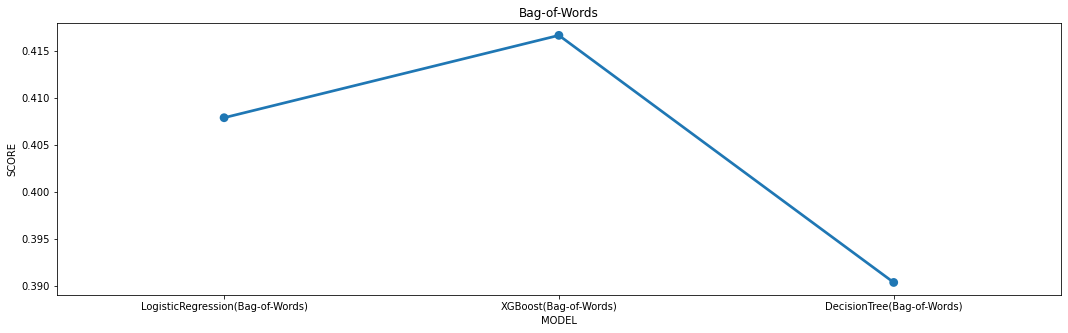

In [77]:
# Bag-of-Words
import seaborn as sns
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare_1)

plt.title('Bag-of-Words')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

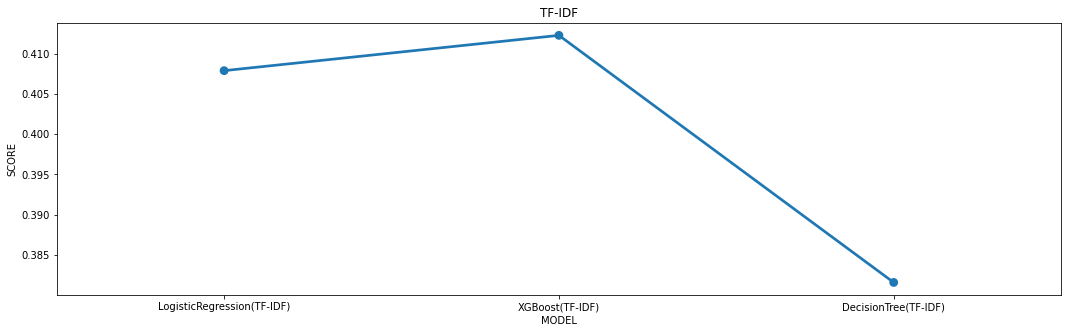

In [78]:
# TF-IDF
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare_2)

plt.title('TF-IDF')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

#Playing around with auto-sklearn 
####since F1 score quite low so I try to use auto ML to improve score - try auto-sklearn

In [79]:
!apt-get install swig -y
!pip install Cython numpy

# sometimes you have to run the next command twice on colab
# I haven't figured out why
!pip install auto-sklearn
# ignore some annoying warnings for demonstrating auto-sklearn 
# shouldn't be done in real production
import numpy as np
np.warnings.filterwarnings('ignore')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
import autosklearn.classification
import sklearn.model_selection
import sklearn.datasets
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [0]:
#bag-of-words
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = sklearn.model_selection.train_test_split(df_bow,df['sentiments'],test_size=0.3,random_state=0)

In [0]:
#tfidf
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = sklearn.model_selection.train_test_split(df_tfidf,df['sentiments'],test_size=0.3,random_state=0)

In [83]:
import autosklearn.classification

# configure auto-sklearn
automl = autosklearn.classification.AutoSklearnClassifier(
          time_left_for_this_task=120, # run auto-sklearn for at most 2min
          per_run_time_limit=30, # spend at most 30 sec for each model training
          )

# train model(s)
automl.fit(x_train_tfidf, y_train_tfidf)

# evaluate
y_hat = automl.predict(x_valid_tfidf)
test_acc = sklearn.metrics.accuracy_score(y_valid_tfidf, y_hat)
print("Accuracy score {0}".format(test_acc))
print("", sklearn.metrics.confusion_matrix(y_valid_tfidf, y_hat))
print("", sklearn.metrics.classification_report(y_valid_tfidf, y_hat))

[WARNING] [2020-04-21 07:10:47,946:EnsembleBuilder(1):32e154528d9f7dfea0aadcebd5be1eb5] No models better than random - using Dummy Score!
[WARNING] [2020-04-21 07:10:47,960:EnsembleBuilder(1):32e154528d9f7dfea0aadcebd5be1eb5] No models better than random - using Dummy Score!
[WARNING] [2020-04-21 07:10:49,965:EnsembleBuilder(1):32e154528d9f7dfea0aadcebd5be1eb5] No models better than random - using Dummy Score!
[WARNING] [2020-04-21 07:10:51,973:EnsembleBuilder(1):32e154528d9f7dfea0aadcebd5be1eb5] No models better than random - using Dummy Score!
[WARNING] [2020-04-21 07:10:53,979:EnsembleBuilder(1):32e154528d9f7dfea0aadcebd5be1eb5] No models better than random - using Dummy Score!
[WARNING] [2020-04-21 07:10:55,986:EnsembleBuilder(1):32e154528d9f7dfea0aadcebd5be1eb5] No models better than random - using Dummy Score!
[WARNING] [2020-04-21 07:10:57,992:EnsembleBuilder(1):32e154528d9f7dfea0aadcebd5be1eb5] No models better than random - using Dummy Score!
[WARNING] [2020-04-21 07:10:59,999